In [18]:
import pyodbc
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [19]:
# Parámetros de conexión
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'

# Conexión a SQL Server local
local_conn_local = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes"

In [20]:
with open('../database/sql/prediccion_PVP.sql', 'r') as file:
    query = file.read()

conn = pyodbc.connect(local_conn_local)
df = pd.read_sql_query(query, conn)
conn.close()

In [21]:
df.head()

,PVP,Edad_Media_Coche,Km_Medio_Por_Revision,Revisiones_Media,churn_percentage
0,21818,1.979167,56905,1.0,0.104167
1,22814,2.015873,31952,1.0,0.365079
2,31968,3.166667,93782,1.0,0.166667
3,28719,1.666667,58609,1.0,0.000000
4,17550,1.953271,39867,1.0,0.154206


In [22]:
df.dtypes

PVP                        int64
Edad_Media_Coche         float64
Km_Medio_Por_Revision      int64
Revisiones_Media         float64
churn_percentage         float64
dtype: object

In [23]:
df.describe()

,PVP,Edad_Media_Coche,Km_Medio_Por_Revision,Revisiones_Media,churn_percentage
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,24063.444115,2.017138,38664.610287,1.000280,0.117426
std,5889.838997,0.769485,26341.123490,0.001728,0.162168
min,10528.000000,-1.000000,0.000000,1.000000,0.000000
25%,20359.000000,1.750000,22382.000000,1.000000,0.000000
50%,23909.000000,2.016334,39469.000000,1.000000,0.071429
75%,28183.500000,2.285714,52167.000000,1.000000,0.181818
max,37970.000000,5.000000,204640.000000,1.027027,1.000000


In [24]:
df.isnull().sum() # Valores nulos.

PVP                      0
Edad_Media_Coche         0
Km_Medio_Por_Revision    0
Revisiones_Media         0
churn_percentage         0
dtype: int64

In [25]:
df.duplicated().sum() # Valores duplicados.

np.int64(0)

In [26]:
# Definición de variables predictoras (X) y variable objetivo (y).
X = df[['PVP', 'Edad_Media_Coche', 'Km_Medio_Por_Revision', 'Revisiones_Media']]
y = df['churn_percentage']

In [27]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [28]:
# Predicción del Churn.
y_pred = model.predict(X)
y_pred_clipped = np.clip(y_pred, 0, 1)

In [29]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, y_pred_clipped)
mse = mean_squared_error(y, y_pred_clipped)
metrics_df = pd.DataFrame({
    'Métrica': ['R² (coef. de determinación)', 'MSE (error cuadrático medio)'],
    'Valor': [r2, mse]
})

print("Evaluación del modelo:")
display(metrics_df)

Evaluación del modelo:


,Métrica,Valor
0,R² (coef. de determinación),0.219787
1,MSE (error cuadrático medio),0.020498


In [30]:
coef_df = pd.DataFrame({
    'Variable': X.columns.tolist() + ['Intercepto'],
    'Coeficiente': model.coef_.tolist() + [model.intercept_]
})

print("Coeficientes estimados:")
display(coef_df)

Coeficientes estimados:


,Variable,Coeficiente
0,PVP,-7.996622e-06
1,Edad_Media_Coche,6.114896e-02
2,Km_Medio_Por_Revision,7.502743e-07
3,Revisiones_Media,-3.376359e+00
4,Intercepto,3.534802e+00


In [33]:
import pyodbc

# Reabre la conexión
conn = pyodbc.connect("DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=dwh_case1;Trusted_Connection=yes")
cursor = conn.cursor()

table = "Tasa_Churn"

# Crear la tabla si no existe
cursor.execute(f"""
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='{table}' AND xtype='U')
CREATE TABLE {table} (
    Variable NVARCHAR(50) PRIMARY KEY,
    Coeficiente FLOAT
)
""")

# Limpiar tabla antes de insertar nuevos datos
cursor.execute(f"DELETE FROM {table}")

# Insertar coeficientes desde DataFrame
insert_sql = f"INSERT INTO {table} (Variable, Coeficiente) VALUES (?, ?)"
for _, row in coef_df.iterrows():
    cursor.execute(insert_sql, row['Variable'], row['Coeficiente'])

conn.commit()
conn.close()
print(f"Tabla '{table}' creada y poblada correctamente.")


Tabla 'Tasa_Churn' creada y poblada correctamente.


In [35]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


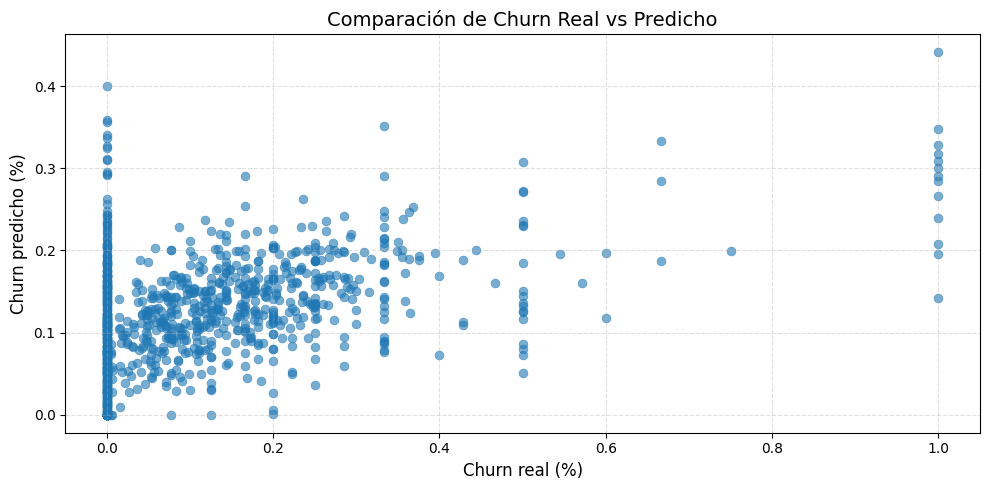

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y, y=y_pred_clipped, alpha=0.6, s=40, edgecolor=None)

plt.xlabel("Churn real (%)", fontsize=12)
plt.ylabel("Churn predicho (%)", fontsize=12)
plt.title("Comparación de Churn Real vs Predicho", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()